Problem taken from Fogler


Author:
 Ali Gabriel Lara

Date: May 2014
Revision: January 2017

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import pandas as pd

In [2]:
plt.style.use('fivethirtyeight')
init_printing(use_latex=True)

# User-defined functions

In [3]:
def XeaTadiabatico(xe, parameters):
    """
    Calculation the conversion at chemical equilibrium
    """
    to, xo = parameters

    t = to + (-Dhr)/CpA * (xe - xo) 
    k1 = k10 * np.exp(-Ea1/R/t) 
    k2 = k20 * np.exp(-Ea2/R/t) 
    ke = k1/k2 

    return xe - ke/(1 + ke)

def EcDisenoPFR(x, v, parameters):
    tin, xin = parameters

    t = tin + (x-xin) * (-Dhr)/CpA 

    kf = k10 * np.exp(-Ea1/R/t) 
    kr = k20 * np.exp(-Ea2/R/t) 

    rate = kf * CA0 * (1-x) - kr * CA0 * x 
    
    # return dVdX = Fao/rate 
    return FA0/rate

# Problem data

In [4]:
# Parametros fijos del problema
HA298 = -40000      # Entalpia de A a 298K, cal/mol
HB298 = -60000      # Entalpia de B a 298K, cal/mol
CpA = 50            # Capacidad calorifica de A cal/mol/K
CpB = 50            # Capacidad calorifica de B cal/mol/K
Ke298 = 100000      # Contante de equilibrio a 298 K
R = 1.987           # cal/mol/K
To = 300            # Temperatura de inicio

k10 = 4.5e1         # Constante cinetica de forward, 1/s
Ea1 = 5000          # Energia de activacion forward, cal/mol/k
k20 = 2.1e11        # Constante cinetica de reverse, 1/s
Ea2 = 25000         # Energia de activacion de reverse, cal/mol/k

# Solution
## Equilibrium conversion plot

Based on van't Hoff equation

$K_e(T) = K_e(298K) + \frac{(HB298 - HA298)}{R}*(1/298-1/T)$


In [5]:
Temperatures = np.linspace(300, 600, 50) 

k1 = k10 * np.exp(-Ea1/R/Temperatures) 
k2 = k20 * np.exp(-Ea2/R/Temperatures) 

Ke = k1/k2 
Xe = Ke/(1 + Ke) 

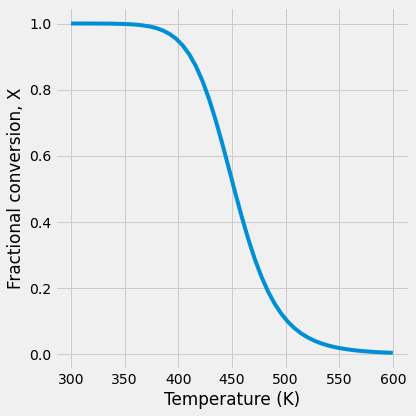

In [6]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(Temperatures, Xe) 

ax.set_xlabel('Temperature (K)') 
ax.set_ylabel('Fractional conversion, X')

plt.tight_layout()
plt.show()

## Energy balance plot

As the reactor operates under adiabatic condition, the equilibrium conversion is:

$ X_e = \frac{C_{P_A}\left(T-To\right)}{-\Delta H_R^\circ} $

In [7]:
Tadia = np.linspace(300, 500, 50) 
Dhr = HB298 - HA298 
Xeadia = CpA * (Tadia - To)/-Dhr 

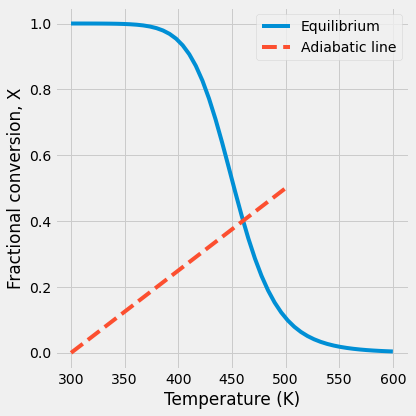

In [8]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(Temperatures, Xe, label='Equilibrium') 
ax.plot(Tadia, Xeadia,ls = '--', label='Adiabatic line') 

ax.set_xlabel('Temperature (K)') 
ax.set_ylabel('Fractional conversion, X')

plt.legend(loc=0)
plt.tight_layout()
plt.show()

## Optimum temperature progression calculation

The objective is finding the reaction temperature which keeps the maximum reaction rate. Thus based on:

\begin{equation}
r = C_{A0} \: k_f(T) * \left( 1 - \frac{1 + Ke(T)}{Ke(T)} \: x \right)
\end{equation}

In [9]:
FA0 = 40    # Flujo molar de A, mol/s
Qin = 0.1   # Caudal de entrada, m^3/s
CA0 = FA0/Qin 

x, t, k10s, k20s, Rs, E1, E2 = symbols('x t k10s k20s Rs E1 E2', real=True, positive=True)
kf, kr, Kes, rs, Xopt = symbols('k1s k2s Kes rs Xopt', cls=Function)

In [10]:
eq01 = Eq(kf(t), k10s * exp(-E1/Rs/t))
eq02 = Eq(kr(t), k20s * exp(-E2/Rs/t)) 
eq03 = Eq(Kes(t), eq01.rhs/eq02.rhs)
eq04 = Eq(rs(t, x), CA0 * eq01.rhs * ( 1 - (1 + eq03.rhs)/eq03.rhs * x))

In [11]:
# Chemical equilibrium constante as a function of T
eq03

In [12]:
# reaction rate as a function of T
eq04

## Locus of maximum reaction rate

In [13]:
eq05 = Eq(Derivative(eq04.lhs, t), Derivative(eq04.rhs, t).doit()).simplify()

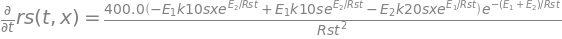

In [14]:
eq05

In [15]:
eq06 = Eq(Xopt(t), solve(eq05.rhs, x)[0])

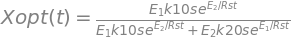

In [16]:
eq06

In [17]:
eq07 = eq06.subs({E1:Ea1, E2:Ea2, 
                 k10s:k10, k20s:k20,
                 Rs:R})

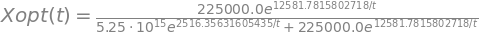

In [18]:
eq07

In [19]:
Conv_progression = lambdify(t, eq07.rhs)

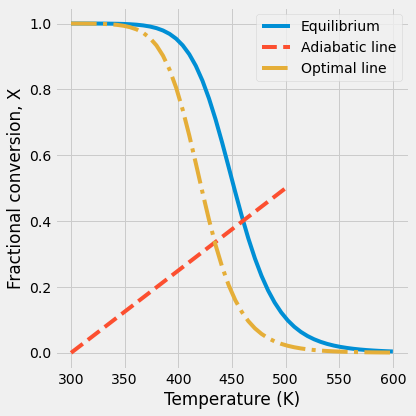

In [20]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(Temperatures, Xe, label='Equilibrium') 
ax.plot(Tadia, Xeadia, ls = '--', label='Adiabatic line')
ax.plot(Temperatures, Conv_progression(Temperatures),
       ls='-.', label='Optimal line')

ax.set_xlabel('Temperature (K)') 
ax.set_ylabel('Fractional conversion, X')

plt.legend(loc=0)
plt.tight_layout()
plt.show()

In [21]:
Stages = np.arange(1, 4)
Tcool = 350
Conv_target = .95

seed = 0.5 
Xo = 0 
parameters = [To, Xo] 

In [22]:
Xe_stage = []
X_stage = []
T_stage = []
for stage in Stages:
    if stage > 1:
        Xo = X_stage[-1]
        To = Tcool
        print(To)
        parameters = [To, Xo]
    
    fun1 = lambda x: XeaTadiabatico(x, parameters)
    Xe_stage.append(fsolve(fun1, seed)[0])
    X_stage.append(Xe_stage[-1] * Conv_target)

    # Stage temperature
    T_stage.append(To + (X_stage[-1] - Xo) * (-Dhr)/CpA)
    
# Interstage Exchange Heat
Xe_stage = np.array(Xe_stage)
X_stage = np.array(X_stage)
T_stage = np.array(T_stage)

Fb = FA0 * X_stage 
Q = FA0 * (1 - X_stage) * CpA * (T_stage - Tcool) + Fb * CpB * (T_stage - Tcool)

350
350


**Summary of calculation by stage**

In [23]:
print('The overall cooling load is {:.1f} kW'.format(Q.sum()/1000)) 

The overall cooling load is 491.0 kW


In [24]:
Vt2 = [(val[0], val[1], Tcool, val[1]) for i, val in enumerate(zip(T_stage, X_stage))]

In [25]:
Vt2 = np.reshape(np.insert(np.array(Vt2).flatten(), 0, [300,0]), (-1,2))

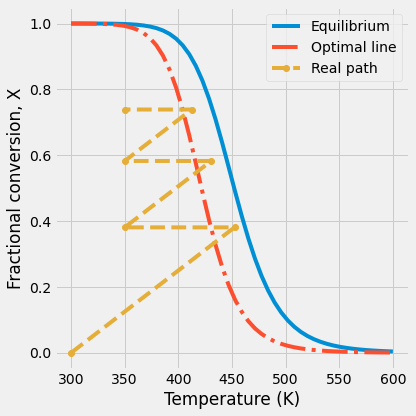

In [26]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(Temperatures, Xe, label='Equilibrium') 
ax.plot(Temperatures, Conv_progression(Temperatures),
       ls='-.', label='Optimal line')
ax.plot(Vt2[:,0], Vt2[:,1],'--o',label='Real path') 

ax.set_xlabel('Temperature (K)') 
ax.set_ylabel('Fractional conversion, X')

plt.legend(loc=0)
plt.tight_layout()
plt.show()

# Calculation of the required volume for each stage assuming an ideal PFR

The initial conditions for each stage are already store in the variable Vt2

In [27]:
conditions_integration = Vt2[::2]

In [28]:
conditions_integration 

array([[300.        ,   0.        ],
       [350.        ,   0.38094745],
       [350.        ,   0.58260273],
       [350.        ,   0.73878719]])

In [29]:
vol_pfr = []
plot_pfr = {}
for i in np.arange(len(conditions_integration)-1):
    Xini = conditions_integration[i, 1]
    Xend = conditions_integration[i+1, 1]
    Xrange = np.linspace(Xini, Xend, 50) 
    ic = [0]
    
    pars = conditions_integration[i]
    fun2 = lambda x, v: EcDisenoPFR(x, v, pars)
    solution = solve_ivp(fun2, [Xini, Xend], ic, t_eval=Xrange)
    vol_pfr.append(solution.y[0][-1])
    plot_pfr.update({str(i+1): [solution.y[0], solution.t]})

In [30]:
summary = np.vstack((Xe_stage, X_stage, T_stage, Q/1000, np.array(vol_pfr)*1000)).T

In [31]:
pd.DataFrame(summary,
             columns=['Xeq', 'Xa', 'Temp (K)', 'Cooling load (kW)', 'Volume reactor (L)'],
             index=Stages)

,Xeq,Xa,Temp (K),Cooling load (kW),Volume reactor (L)
1,0.400997,0.380947,452.378980,204.757959,1218.089929
2,0.613266,0.582603,430.662114,161.324228,630.744267
3,0.777671,0.738787,412.473781,124.947561,838.734572


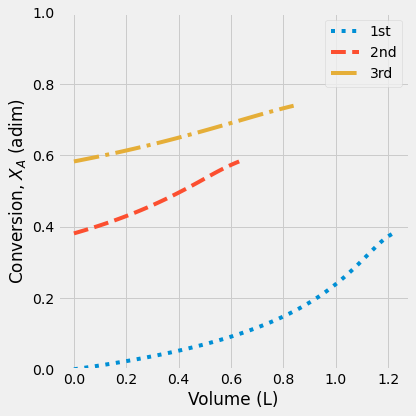

In [32]:
labels = ['1st', '2nd', '3rd']
lss = {'--', ':', '-.'}

fig, ax = plt.subplots(figsize=(6, 6))
for i, (label, ls) in enumerate(zip(labels, lss)):
    vol = plot_pfr[str(i+1)][0]
    conv = plot_pfr[str(i+1)][1]
    ax.plot(vol, conv, ls=ls, label=label)

ax.set_xlabel('Volume (L)')
ax.set_ylabel('Conversion, $X_A$ (adim)')
ax.set_ylim([0,1])
plt.legend()
plt.tight_layout()
plt.show()